# Deep Learning avecPyTorch

In [10]:
import pandas as pd
import re, collections
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# Si ce n’est déjà fait, charge ton DataFrame
df = pd.read_csv("fake_news_sample_categorised.csv", encoding="utf-8")

# On ne garde que les colonnes utiles pour cette étape
texts  = df["post_clean"].astype(str).tolist()
labels = torch.tensor(df["fake"].values, dtype=torch.long)

# 1) Construction d’un vocabulaire (<= 5 000 mots)
# Tokenisation ultra-simple sur les espaces + nettoyage basique
tokenizer = lambda s: re.findall(r"\b\w+\b", s.lower())

counter = collections.Counter()
for txt in texts:
    counter.update(tokenizer(txt))

# On réserve 2 index spéciaux : PAD = 0, UNK = 1
vocab_size = 5_000
most_common = counter.most_common(vocab_size - 2)          # -2 car PAD/UNK
idx2tok = ["<PAD>", "<UNK>"] + [tok for tok, _ in most_common]
tok2idx = {tok: idx for idx, tok in enumerate(idx2tok)}

# 2) Texte -> séquence d’index + 3) padding à 200
max_len = 200
unk = tok2idx["<UNK>"]
pad = tok2idx["<PAD>"]

def encode(text):
    ids = [tok2idx.get(t, unk) for t in tokenizer(text)][:max_len]
    if len(ids) < max_len:                      # padding à droite
        ids += [pad] * (max_len - len(ids))
    return ids

input_ids = torch.tensor([encode(t) for t in texts], dtype=torch.long)

# 4) TensorDataset prêt pour DataLoader
dataset = TensorDataset(input_ids, labels)

print("Taille vocabulaire :", len(tok2idx))
print("Shape input_ids   :", input_ids.shape)
print("Dataset lenght    :", len(dataset))


Taille vocabulaire : 5000
Shape input_ids   : torch.Size([9552, 200])
Dataset lenght    : 9552



Vocabulaire : on compte les mots les plus fréquents et on garde les 4 998 premiers (les 2 autres index sont réservés).

Encodage : chaque post est tokenisé, converti en index (UNK si mot hors-vocab) puis complété avec des PAD jusqu’à 200 tokens.

TensorDataset : on obtient enfin des tenseurs input_ids de taille (N, 200) et labels de taille (N,) pour l’apprentissage d’un modèle (logistic regression, réseaux neuronaux, fine-tuning Transformer, etc..)



[1/12]  loss = 0.5432
[2/12]  loss = 0.2414
[3/12]  loss = 0.1405
[4/12]  loss = 0.0980
[5/12]  loss = 0.0742
[6/12]  loss = 0.0579
[7/12]  loss = 0.0461
[8/12]  loss = 0.0373
[9/12]  loss = 0.0304
[10/12]  loss = 0.0250
[11/12]  loss = 0.0210
[12/12]  loss = 0.0178

Accuracy test = 0.950


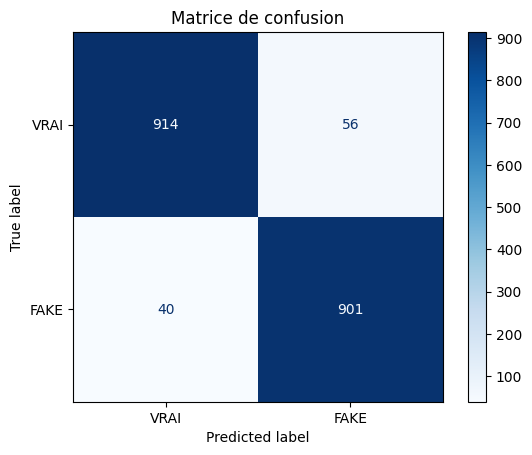

In [11]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SZ = 64
EPOCHS   = 12       # 10-15 époques recommandées
LR       = 2e-3
EMB_DIM  = 128

# 1) DataLoader train / test (80 % / 20 %)
N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train
train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SZ)

# 2) Modèle : Embedding  + GlobalAvgPool  + MLP
class FakeNewsNet(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.fc        = nn.Linear(emb_dim, 64)
        self.out       = nn.Linear(64, 1)

    def forward(self, x):
        # x : (B, seq_len)
        emb = self.embedding(x)                       # (B, L, D)
        pooled = emb.mean(dim=1)                      # Global average pooling (B, D)
        h = torch.relu(self.fc(pooled))               # (B, 64)
        logits = self.out(h).squeeze(1)               # (B,)
        return logits                                 # on renverra les logits

model = FakeNewsNet(vocab_size=len(tok2idx), emb_dim=EMB_DIM).to(device)

# 3) Optimiseur & fonction de coût
criterion = nn.BCEWithLogitsLoss()
optim     = torch.optim.Adam(model.parameters(), lr=LR)

# 4) Boucle d’entraînement
train_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for X, y in train_loader:
        X, y = X.to(device), y.float().to(device)

        optim.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward()
        optim.step()

        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / n_train
    train_losses.append(epoch_loss)
    print(f"[{epoch}/{EPOCHS}]  loss = {epoch_loss:.4f}")

# 5) Évaluation sur le jeu de test
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy test = {acc:.3f}")

# 6) Matrice de confusion & courbe de loss
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["VRAI", "FAKE"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()


On a entraîné un modèle pour détecter si une information est vraie ou fausse. Pendant l’entraînement, la perte a bien diminué, passant de 0.54 à 0.017 en 12 époques, ce qui montre que le modèle a bien appris. Sur le jeu de test, on obtient 95 % de précision, donc le modèle se débrouille très bien même avec des données qu’il ne connaît pas.
En regardant la matrice de confusion :
- On a correctement identifié 914 vraies informations (vrais positifs)
- et 901 fausses informations (vrais négatifs),
- il s’est trompé 40 fois en prenant des fake news pour des vraies (faux positifs)
- et 56 fois dans l’autre sens (faux négatifs).
En résumé, le modèle est assez équilibré et performant, avec peu d’erreurs et une bonne capacité à généraliser.

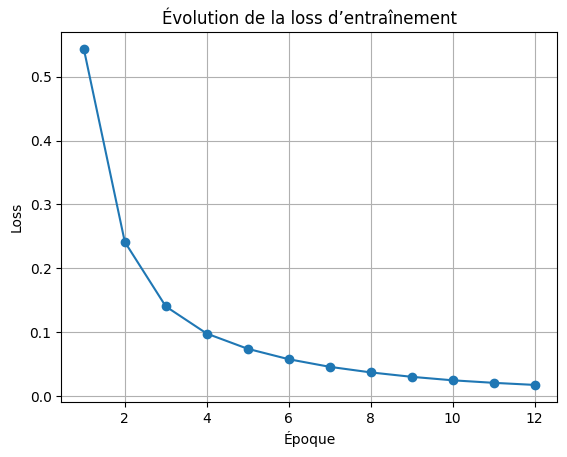

In [12]:
plt.figure()
plt.plot(range(1, EPOCHS + 1), train_losses, marker="o")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Évolution de la loss d’entraînement")
plt.grid(True)
plt.show()

Le graphique ci-dessus illustre l’évolution de la loss (ou fonction de perte) au cours de 12 époques d’entraînement d’un modèle de machine learning. On observe que la loss diminue de manière significative au fil des itérations, ce qui est un bon indicateur de l’apprentissage progressif du modèle.

Dès la première époque, la loss est relativement élevée (environ 0,55), ce qui est normal, car le modèle commence sans connaissance préalable. Ensuite, on constate une chute rapide entre les époques 1 et 3, montrant une phase d’apprentissage rapide. Cela signifie que le modèle parvient très vite à capter les grandes tendances des données.

À partir de l’époque 4, la courbe commence à se stabiliser et la baisse devient plus progressive. À la fin de l’entraînement (époque 12), la loss atteint une valeur très faible, proche de 0, ce qui indique que le modèle fait très peu d’erreurs sur les données d’entraînement.

Globalement, cette courbe en décroissance rapide puis asymptotique est typique d’un bon entraînement supervisé, où le modèle converge efficacement vers une solution optimale. Cependant, il faudrait aussi vérifier les performances sur les données de validation pour s’assurer qu’il n’y a pas de surapprentissage (overfitting).